In [2]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt



In [49]:
# df = pd.read_csv('processed_data/data.csv')
df = pd.read_csv('processed_data/combined_boxscores.csv')
df = df.sort_values('game_day').reset_index(drop=True)
exclude_cols = ['pts_home','pts_away','game_id', 'team','team_home','home_team','team_away','away_team', 'game_day','other_team_score','score_other','score','target']
stat_cols = ['fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta',
       'oreb', 'dreb', 'reb', 'ast', 'stl', 'blk', 'to', 'pf']
cumul_cols = [x for x in df.columns if 'cumul' in x]
test_removal = ['home_rank','away_rank','is_home']
df = df.dropna()


In [40]:
df[df['game_id']==401575451]

,game_id,team_home,fgm_home,fga_home,2pm_home,2pa_home,3pm_home,3pa_home,ftm_home,fta_home,...,ftm_away,fta_away,oreb_away,dreb_away,reb_away,ast_away,stl_away,blk_away,to_away,pf_away
0,401575451,Kansas Jayhawks,0.709091,0.54902,0.530612,0.44,0.590909,0.442308,0.2,0.196078,...,0.25,0.352941,0.272727,0.25,0.2875,0.189189,0.304348,0.055556,0.257143,0.325


In [41]:
# df = df[df['is_home']==1]

In [42]:
df.columns

Index(['game_id', 'team_home', 'fgm_home', 'fga_home', '2pm_home', '2pa_home',
       '3pm_home', '3pa_home', 'ftm_home', 'fta_home', 'oreb_home',
       'dreb_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'to_home',
       'pf_home', 'pts_home', 'home_rank', 'away_team', 'away_rank',
       'is_conference', 'is_neutral', 'game_day', 'homeTeam_wins',
       'homeTeam_losses', 'awayTeam_wins', 'awayTeam_losses', 'home_team',
       'team_away', 'pts_away', 'fgm_away', 'fga_away', '2pm_away', '2pa_away',
       '3pm_away', '3pa_away', 'ftm_away', 'fta_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'to_away',
       'pf_away'],
      dtype='object')

In [9]:
df.shape

(4245, 63)

In [45]:
df['pts_home'].describe()

count    4607.000000
mean       75.319080
std        12.089234
min         0.000000
25%        67.000000
50%        75.000000
75%        83.000000
max       134.000000
Name: pts_home, dtype: float64

<AxesSubplot: xlabel='pts_home', ylabel='Count'>

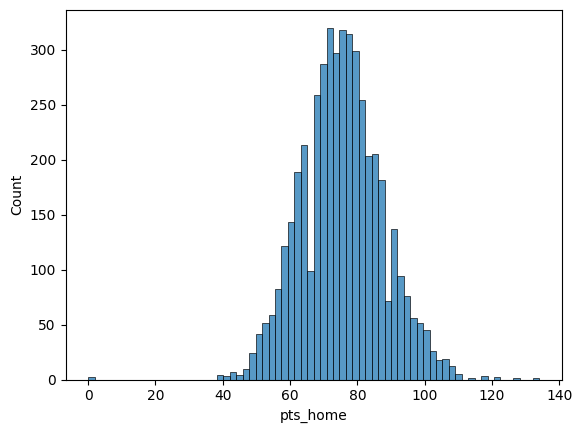

In [47]:
sns.histplot(df['pts_home'])

In [50]:
df = df[(df['pts_home']>=60) & (df['pts_home']<=90)] #& (df['prev_scores_cum_avg']>=60) & (df['prev_scores_cum_avg']<=90)]

<AxesSubplot: xlabel='pts_home', ylabel='Count'>

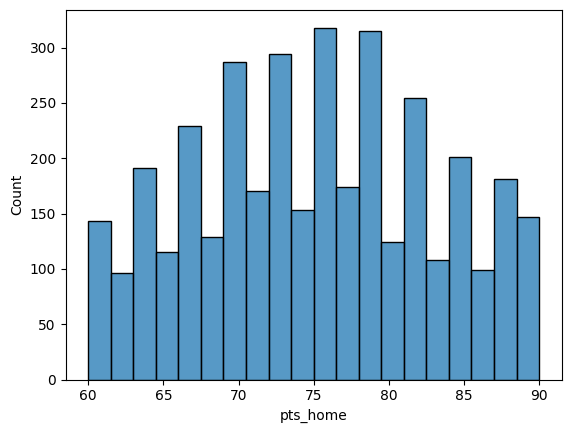

In [52]:
sns.histplot(df['pts_home'])

<AxesSubplot: xlabel='fgm_home', ylabel='pts_home'>

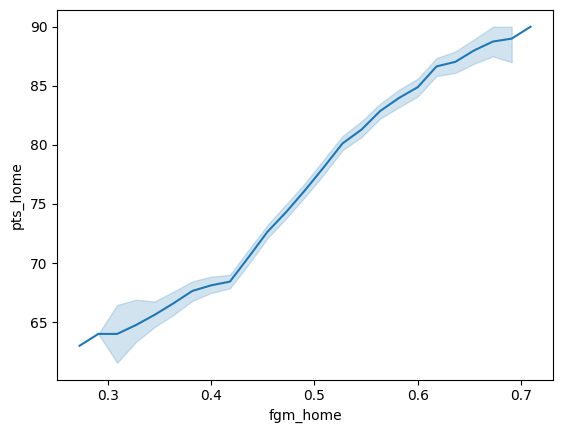

In [54]:
sns.lineplot(x=df['fgm_home'],y=df['pts_home'])

In [55]:
# plt.figure(figsize=(12,16))
# plt.subplots_adjust(hspace=0.6,wspace=0.6)
# # for col in stat_cols:
# #     sns.lineplot(x=df['fgm'],y=df['score'])
# for i, col in enumerate(feature_cols):
#     plt.subplot(5, 5, i+1)
#     sns.lineplot(x=df[col],y=df['score'])
#     plt.title(col)

In [56]:
df[stat_cols].describe()

KeyError: "None of [Index(['fgm', 'fga', '2pm', '2pa', '3pm', '3pa', 'ftm', 'fta', 'oreb', 'dreb',\n       'reb', 'ast', 'stl', 'blk', 'to', 'pf'],\n      dtype='object')] are in the [columns]"

In [295]:
home_rr = RidgeClassifier(alpha=1)
away_rr = RidgeClassifier(alpha=1)
split=TimeSeriesSplit(n_splits=3)

home_sfs= SequentialFeatureSelector(rr, n_features_to_select=30, direction='forward', cv=split)
away_sfs= SequentialFeatureSelector(rr, n_features_to_select=20, direction='forward', cv=split)

In [255]:
feature_cols = df.columns[~df.columns.isin(exclude_cols+test_removal+cumul_cols)]
home_target_col = 'pts_home'
away_target_col = 'pts_away'

In [63]:
feature_cols,len(feature_cols)

(Index(['fgm_home', 'fga_home', '2pm_home', '2pa_home', '3pm_home', '3pa_home',
        'ftm_home', 'fta_home', 'oreb_home', 'dreb_home', 'reb_home',
        'ast_home', 'stl_home', 'blk_home', 'to_home', 'pf_home',
        'is_conference', 'is_neutral', 'homeTeam_wins', 'homeTeam_losses',
        'awayTeam_wins', 'awayTeam_losses', 'fgm_away', 'fga_away', '2pm_away',
        '2pa_away', '3pm_away', '3pa_away', 'ftm_away', 'fta_away', 'oreb_away',
        'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'to_away',
        'pf_away'],
       dtype='object'),
 38)

In [288]:
def backtest(data, target_col, model, predictors, start=2, step=1):
    all_predictions=[]
    unique_days=sorted(df['game_day'].unique())

    for i in range(start, len(unique_days), step):
        day = unique_days[i]
        train = df[df['game_day']<day]
        test = df[df['game_day']==day]

        model.fit(train[predictors], train[target_col])
        
        preds = model.predict(test[predictors]) 
        preds = pd.Series(preds, index=test.index)

        combined = pd.concat([test[target_col], preds], axis=1)
        combined.columns = ['actual','prediction']

        all_predictions.append(combined)
    return model, pd.concat(all_predictions)


In [297]:
away_sfs.fit(df[feature_cols],df[away_target_col])
away_predictors = list(feature_cols[away_sfs.get_support()])
away_model, away_predictions = backtest(df, away_target_col, away_rr, away_predictors)

In [261]:
home_sfs.fit(df[feature_cols],df[home_target_col])
home_predictors = list(feature_cols[home_sfs.get_support()])
home_model, home_predictions = backtest(df, home_target_col, home_rr, home_predictors)

In [298]:
print("HOME EVALUATIONS:")
print("r2:", r2_score(home_predictions['actual'],home_predictions['prediction']))
print("MAE:", mean_absolute_error(home_predictions['actual'],home_predictions['prediction']))
print()
print("AWAY EVALUATIONS:")
print("r2:", r2_score(away_predictions['actual'],away_predictions['prediction']))
print("MAE:", mean_absolute_error(away_predictions['actual'],away_predictions['prediction']))

HOME EVALUATIONS:
r2: 0.6267320211503078
MAE: 3.850041197473222

AWAY EVALUATIONS:
r2: 0.5783305582547231
MAE: 5.540510848667949


In [291]:
def findCumulAvgs(team):
    rolling = team.expanding().mean()
    return rolling

In [195]:
game_info_df = pd.read_csv('raw_data/game_info_df.csv')
game_info_df = game_info_df.dropna(subset=['home_record','away_record'])


In [189]:
game_info_df.columns

Index(['game_id', 'home_team', 'home_id', 'home_rank', 'home_record',
       'home_score', 'away_team', 'away_id', 'away_rank', 'away_record',
       'away_score', 'home_win', 'num_ots', 'is_conference', 'is_neutral',
       'is_postseason', 'tournament', 'game_day', 'game_time', 'game_loc',
       'arena', 'arena_capacity', 'attendance', 'tv_network', 'referee_1',
       'referee_2', 'referee_3'],
      dtype='object')

In [196]:
exclude_boxscore_cols = ['player', 'player_id', 'position', 'starter', 'min']
boxscore_df = pd.read_csv('raw_data/boxscore_df.csv')

# Join into to get game info
boxscore_df = pd.merge(boxscore_df, game_info_df[['game_id','game_day','home_record','away_record']], on='game_id')
boxscores_filtered = boxscore_df[(boxscore_df.player_id == 'TOTAL')]
scaler = MinMaxScaler()
boxscores_filtered[stat_cols] = scaler.fit_transform(boxscores_filtered[stat_cols])
boxscores_filtered = boxscores_filtered.drop(exclude_boxscore_cols,axis=1).reset_index(drop=True)
boxscores_cumul_avgs = boxscores_filtered.groupby('team',group_keys=False)[stat_cols].apply(findCumulAvgs)
boxscores_final = pd.concat([boxscores_cumul_avgs, boxscores_filtered[['game_id','team','game_day','home_record','away_record']]], axis=1)

records_cols = ['home_record','away_record']
# Convert Record cols to Wins and Losses cols
for col in records_cols:
    team_type = col.split('_')[0]
    boxscores_final[col] = boxscores_final[col].astype(str)
    wins = boxscores_final.loc[:,col].apply(lambda x: x.split('-')[0])
    losses = boxscores_final.loc[:,col].apply(lambda x: x.split('-')[1])    
    boxscores_final[team_type+'Team_wins'] = wins
    boxscores_final[team_type+'Team_losses'] = losses
    boxscores_final = boxscores_final.drop(col,axis=1)
# lookup = pd.merge(boxscores_final, )

/var/folders/z_/b2p80qvn353dbq0c1vfq0q600000gq/T/ipykernel_6535/4292779899.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxscores_filtered[stat_cols] = scaler.fit_transform(boxscores_filtered[stat_cols])


# PREDICT

In [254]:
game_date_str = '2024-02-10'
game_date = pd.to_datetime(game_date_str)
boxscores_final['game_day'] = pd.to_datetime(boxscores_final['game_day'])
home_team_name ='Duke Blue Devils'
away_team_name = 'Boston College Eagles'
home_most_recent_bs = pd.DataFrame(boxscores_final[(boxscores_final['team']==home_team_name) & (boxscores_final['game_day']<game_date)].iloc[-1,:]).transpose()
away_most_recent_bs = pd.DataFrame(boxscores_final[(boxscores_final['team']==away_team_name) & (boxscores_final['game_day']<game_date)].iloc[-1,:]).transpose()

In [233]:
home_team_cols_needed = {}
for f in feature_cols:
    if '_home' in f:
        home_team_cols_needed[f.replace('_home','')]=f
home_most_recent_bs=home_most_recent_bs.rename(columns=home_team_cols_needed)
home_most_recent_bs=home_most_recent_bs.drop(['awayTeam_wins','awayTeam_losses'],axis=1)

away_team_cols_needed = {}
for f in feature_cols:
    if '_away' in f:
        away_team_cols_needed[f.replace('_away','')]=f
away_most_recent_bs=away_most_recent_bs.rename(columns=away_team_cols_needed)
away_most_recent_bs=away_most_recent_bs.drop(['homeTeam_wins','homeTeam_losses'],axis=1)

home_most_recent_bs['join_helper']=1
away_most_recent_bs['join_helper']=1

validate_df = pd.merge(home_most_recent_bs, away_most_recent_bs,on='TEST')
validate_df['is_neutral']=0
validate_df['is_conference']=1

In [246]:
validate_df

,fgm_home,fga_home,2pm_home,2pa_home,3pm_home,3pa_home,ftm_home,fta_home,oreb_home,dreb_home,...,blk_away,to_away,pf_away,game_id_y,team_y,game_day_y,awayTeam_wins,awayTeam_losses,is_neutral,is_conference
0,0.549825,0.618845,0.514773,0.52904,0.421053,0.435065,0.3875,0.417112,0.296143,0.538033,...,0.230114,0.35303,0.389773,401604170,Boston College Eagles,2024-02-06,13,9,0,1


In [300]:
home_pred = home_model.predict(validate_df[home_predictors]) 
away_pred = away_model.predict(validate_df[away_predictors])


In [301]:
print('HOME:',home_pred[0])
print('AWAY:',away_pred[0])

HOME: 82
AWAY: 71


In [280]:
feature_cols

Index(['fgm_home', 'fga_home', '2pm_home', '2pa_home', '3pm_home', '3pa_home',
       'ftm_home', 'fta_home', 'oreb_home', 'dreb_home', 'reb_home',
       'ast_home', 'stl_home', 'blk_home', 'to_home', 'pf_home',
       'is_conference', 'is_neutral', 'homeTeam_wins', 'homeTeam_losses',
       'awayTeam_wins', 'awayTeam_losses', 'fgm_away', 'fga_away', '2pm_away',
       '2pa_away', '3pm_away', '3pa_away', 'ftm_away', 'fta_away', 'oreb_away',
       'dreb_away', 'reb_away', 'ast_away', 'stl_away', 'blk_away', 'to_away',
       'pf_away'],
      dtype='object')

In [302]:
#TODO: increase the start time in the backtest loop?